# HW9: Segmentation and Pose Estimation

Segmentation and pose estimation are among the coolest applications of computer vision.
Recently advanced in both these domains have brought big innovation in consumer products, from surveillence to broadcast media to fitness tracking to precision health and medical care.
We will implement basic versions, but the learnings are all the same!

In this exercise you will implement an image segmentation algorithm based on U-Net [Ronnenberger et al](https://arxiv.org/abs/1505.04597) and a pose estimation / keypoint detection algorithm based on [Thompson et al](https://arxiv.org/abs/1411.4280).

Follow the cells below and complete the missing parts.

Good luck!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import load_img, img_to_array
import keras

## Segmentation

In this part we will implement U-Net for segmentation. It is one of the greatest contributions in the field in the last 10 years and resulted in big innovations and impact.

U-Net is called so because of it's U shape encoder-decoder network architecture.

### Data Loading

First download the Oxford pets dataset with segmentation annotation.

Let's load the data and visualize a sample from it.

In [2]:
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
!curl -O https://thor.robots.ox.ac.uk/datasets/pets/annotations.tar.gz

!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

^C


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1 18.2M    1  239k    0     0   248k      0  0:01:15 --:--:--  0:01:15  248k
  8 18.2M    8 1615k    0     0   834k      0  0:00:22  0:00:01  0:00:21  834k
 14 18.2M   14 2751k    0     0   935k      0  0:00:20  0:00:02  0:00:18  935k
 20 18.2M   20 3839k    0     0   970k      0  0:00:19  0:00:03  0:00:16  970k
 26 18.2M   26 4975k    0     0  1007k      0  0:00:18  0:00:04  0:00:14 1007k
 32 18.2M   32 6031k    0     0  1014k      0  0:00:18  0:00:05  0:00:13 1163k
 37 18.2M   37 7039k    0     0  1013k      0  0:00:18  0:00:06  0:00:12 1082k
 42 18.2M   42 7935k    0     0   996k      0  0:00:18  0:00:07  0:00:11 1032k
 46 18.2M   46 8639k    0     0   964k      0  0:00:19  0:00:08  0:00:11  959k
 49 18.2M   49 9247k    0     0   926k      0  0:00

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  755M    0  639k    0     0   489k      0  0:26:19  0:00:01  0:26:18  489k
  0  755M    0 1647k    0     0   710k      0  0:18:08  0:00:02  0:18:06  710k
  0  755M    0 2591k    0     0   780k      0  0:16:30  0:00:03  0:16:27  781k
  0  755M    0 3087k    0     0   715k      0  0:18:00  0:00:04  0:17:56  716k
  0  755M    0 3519k    0     0   663k      0  0:19:26  0:00:05  0:19:21  705k
  0  755M    0 3967k    0     0   627k      0  0:20:32  0:00:06  0:20:26  663k
  0  755M    0 4479k    0     0   609k      0  0:21:09  0:00:07  0:21:02  562k
  0  755M    0 5071k    0     0   605k      0  0:21:16  0:00:08  0:21:08  490k
  0  755M    0 5727k    0     0   612k      0  0:21

In [3]:
import os

# your input directory location may change, e.g. if you're on colab or a local machine
input_dir = "./images"
target_dir = "./annotations/trimaps"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 263
./images\Abyssinian_10.jpg | ./annotations/trimaps\Abyssinian_1.png
./images\Abyssinian_136.jpg | ./annotations/trimaps\Abyssinian_10.png
./images\Abyssinian_140.jpg | ./annotations/trimaps\Abyssinian_100.png
./images\Abyssinian_174.jpg | ./annotations/trimaps\Abyssinian_101.png
./images\Abyssinian_219.jpg | ./annotations/trimaps\Abyssinian_102.png
./images\Abyssinian_228.jpg | ./annotations/trimaps\Abyssinian_103.png
./images\Abyssinian_26.jpg | ./annotations/trimaps\Abyssinian_104.png
./images\Abyssinian_37.jpg | ./annotations/trimaps\Abyssinian_105.png
./images\Abyssinian_6.jpg | ./annotations/trimaps\Abyssinian_106.png
./images\Abyssinian_65.jpg | ./annotations/trimaps\Abyssinian_107.png


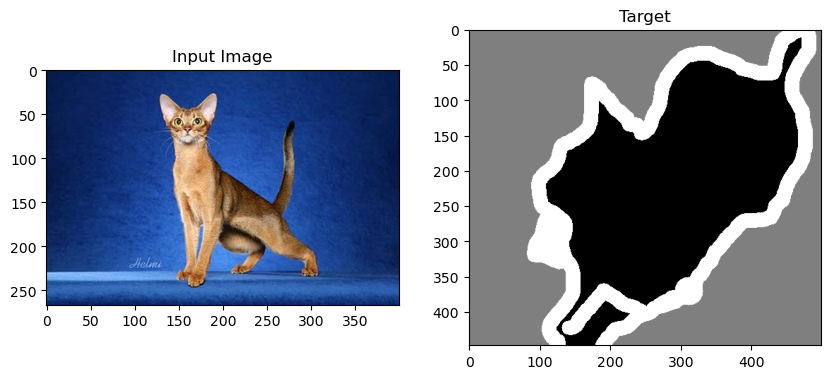

In [4]:
from IPython.display import display
from PIL import ImageOps
import matplotlib.pyplot as plt

# Load an input image
input_image = plt.imread(input_img_paths[9])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")

# Load and auto-contrast version of corresponding target (per-pixel categories)
target_image = ImageOps.autocontrast(load_img(target_img_paths[9]))
target_image = np.float32(img_to_array(target_image) / 255.0)

# Display auto-contrast version of corresponding target
plt.subplot(1, 2, 2)
plt.imshow(target_image)
plt.title("Target")
plt.show()


Let's build a TF Dataset to easily read the images and annotations

In [8]:
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io


def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

### Model Implementation

Let's build a simple U-Net model.

The model consists of a convolutional Encoder with 3 layers where each has stacked 2D seperable convolutions (they have less weights).

We will also add a residual connection - taking the output of the last layer, upsampling it, and adding it back to the output of the current layer.

![image.png](attachment:image.png)

This follows [Ronnenberger et al](https://arxiv.org/pdf/1505.04597.pdf) closely.

In [10]:
from keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    # add a conv2d layer with 32 filters, 3x3 kernel size, and stride of 2
    x = layers.Conv2D(32, 3, strides = 2, padding="same")(inputs)
    # add batch normalization
    x = layers.BatchNormalization()(x)
    # add a relu activation
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    skip_connections = [x]

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        # add activation on top of previous x
        x = layers.Activation("relu")(x)
        # add a separable conv2d layer with filters, 3x3 kernel size, and padding same
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        # add batch normalization
        x = layers.BatchNormalization()(x)

        # same again
        # add activation on top of previous block
        x = layers.Activation("relu")(x)
        # add a separable conv2d layer with filters, 3x3 kernel size, and padding same
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        # add batch normalization
        x = layers.BatchNormalization()(x)

        # save the outputs to be used in skip connections
        skip_connections.append(x)

        # add a max pooling layer with pool size 3 and stride 2
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        # add a conv2d layer with filters, 1x1 kernel size, and stride of 2
        # on top of previous_block_activation
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for i, filters in enumerate( [256, 128, 64, 32]):
        if i > 0: # dont add skip connections for the lowest block...
            # add skip connections from conv_activations as input to this block
            # use layers.Concatenate() to concatenate x and skip_connections[-i]
            x = layers.Concatenate()([x, skip_connections[-i]])

        # similar to the encoder
        # add relu activation on top of previous block
        x = layers.Activation("relu")(x)
        # add a conv2d *transpose* layer with filters, 3x3 kernel size, and padding same
        x = layers.Conv2DTranspose(filters, 3, padding="same")
        # add batch normalization
        x = layers.BatchNormalization()(x)

        # add activation on top of previous block
        x = layers.Activation("relu")(x)
        # add a conv2d transpose layer with filters, 3x3 kernel size, and padding same
        x = layers.Conv2DTranspose(filters, 3, padding="same")
        # add batch normalization
        x = layers.BatchNormalization()(x)

        # add Upsampling2D layer with size 2
        x = layers.UpSampling2D(2)(x)

        # Project residual
        # upsample the previous_block_activation with factor 2
        residual = layers.UpSampling2D(2)(previous_block_activation)
        # add a conv2d layer with filters, 1x1 kernel size, and padding same
        residual = layers.Conv2D(filters,1, padding="same")(residual)

        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    # use a conv2d layer with num_classes filters, 3x3 kernel size, and padding same
    # with softmax activation, and num_classes as output depth (the tri-map)
    outputs = ...

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Build model
model = get_model(img_size, num_classes)
model.summary()

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <MaxPooling2D name=max_pooling2d, built=False> (of type <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>)

### Prepare data for training

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate dataset for each split
# Limit input files in `max_dataset_len` for faster epoch training time.
# Remove the `max_dataset_len` arg when running with full dataset.
train_dataset = get_dataset(
    batch_size,
    img_size,
    train_input_img_paths,
    train_target_img_paths,
    max_dataset_len=1000,
)
valid_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

### Loss function

We're going to use a combined loss function that will take both pixel-classification and overall segmentation into account.

To do that, implement a cross-entropy loss for every pixel and add a Sørensen-Dice loss (akin to intersection over union).

$$
L_{\text{Dice}} = 1 - \frac{2 \sum_{i=1}^N p_i g_i}{\sum_{i=1}^N p_i^2 + \sum_{i=1}^N g_i^2}
$$

In [ ]:
import tensorflow as tf
import keras.backend as K

@keras.saving.register_keras_serializable(name="CombinedCEAndDiceLoss")
class CombinedLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha

    def dice_loss(self, y_true, y_pred):
        smooth = K.epsilon()

        # Convert y_true to one-hot format with depth 3 (e.g. 0, 1, 2)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)

        # Flatten the tensors
        y_true_f = tf.reshape(y_true_one_hot, [-1, 3])
        y_pred_f = tf.reshape(y_pred, [-1, 3])

        # Calculate Dice coefficient for each class
        # Intersection is the element-wise multiplication of y_true_f and y_pred_f
        # use tf.reduce_sum to sum the intersection over all pixels
        intersection = ...
        # Union is the element-wise sum of true and predicted pixels for each class
        # again use tf.reduce_sum to sum the union over all pixels
        union = ...

        # Calculate Dice coefficient for each class:
        # (2 * intersection + smooth) / (union + smooth)
        dice = ...

        # Dice loss for multi-class, averaged over all classes
        # remember to use 1 - mean(dice) as the dice loss
        # use tf.reduce_mean to average over all classes
        dice_loss = ...

        return dice_loss

    # Define the cross-entropy loss
    def ce_loss(self, y_true, y_pred):
        # y_true is a 4D int8 tensor with shape (batch_size, height, width, 1)
        # y_pred is a 4D int8 tensor with shape (batch_size, height, width, num_classes)

        # use the "sparse" version of categorical_crossentropy
        cross_entropy = ...
        return cross_entropy(y_true, y_pred)

    def call(self, y_true, y_pred):
        # overall loss
        return self.alpha * self.dice_loss(y_true, y_pred) + (1 - self.alpha) * self.ce_loss(y_true, y_pred)

### Model training

Compile the model and run training for 30-50 epochs.

In [ ]:
# Configure the model for training.
model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=CombinedLoss())

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/30


I0000 00:00:1713620856.373335     347 service.cc:145] XLA service 0x7f6d0403ea50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713620856.373404     347 service.cc:153]   StreamExecutor device (0): Quadro P1000, Compute Capability 6.1
2024-04-20 09:47:36.699866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1713620857.232731     347 assert_op.cc:38] Ignoring Assert operator compile_loss/combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-04-20 09:47:39.511691: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-20 09:48:12.037460: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,80,80]{3,2,1,0}, f32[32,

32/32 - 90s - 3s/step - loss: 1.0051 - val_loss: 0.9252
Epoch 2/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 15s - 461ms/step - loss: 0.6669 - val_loss: 1.0895
Epoch 3/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 15s - 472ms/step - loss: 0.5898 - val_loss: 1.4675
Epoch 4/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 15s - 480ms/step - loss: 0.5455 - val_loss: 1.8791
Epoch 5/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 485ms/step - loss: 0.5116 - val_loss: 2.3057
Epoch 6/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 488ms/step - loss: 0.4822 - val_loss: 2.7401
Epoch 7/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 488ms/step - loss: 0.4549 - val_loss: 3.1801
Epoch 8/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 492ms/step - loss: 0.4287 - val_loss: 3.6996
Epoch 9/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 491ms/step - loss: 0.4017 - val_loss: 4.3096
Epoch 10/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.3745 - val_loss: 4.9552
Epoch 11/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 491ms/step - loss: 0.3470 - val_loss: 5.6379
Epoch 12/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 491ms/step - loss: 0.3216 - val_loss: 6.1689
Epoch 13/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.3010 - val_loss: 6.3740
Epoch 14/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 489ms/step - loss: 0.2987 - val_loss: 5.7520
Epoch 15/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 486ms/step - loss: 0.3242 - val_loss: 4.0981
Epoch 16/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 489ms/step - loss: 0.3282 - val_loss: 2.7970
Epoch 17/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.2985 - val_loss: 2.3275
Epoch 18/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 488ms/step - loss: 0.3009 - val_loss: 1.7488
Epoch 19/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 487ms/step - loss: 0.3092 - val_loss: 1.7775
Epoch 20/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 489ms/step - loss: 0.2866 - val_loss: 1.0733
Epoch 21/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 497ms/step - loss: 0.2618 - val_loss: 0.8131
Epoch 22/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 498ms/step - loss: 0.2448 - val_loss: 0.7334
Epoch 23/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.2311 - val_loss: 0.7359
Epoch 24/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.2294 - val_loss: 0.7734
Epoch 25/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 498ms/step - loss: 0.2288 - val_loss: 0.6756
Epoch 26/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 488ms/step - loss: 0.2239 - val_loss: 0.6857
Epoch 27/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.2142 - val_loss: 0.7175
Epoch 28/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.2110 - val_loss: 0.7064
Epoch 29/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.2138 - val_loss: 0.7714
Epoch 30/30


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


32/32 - 16s - 490ms/step - loss: 0.2166 - val_loss: 0.9097


### Prediction and Results analysis

Let's predict some outputs from the validation set and reason about the results.

In [ ]:
# Generate predictions for all images in the validation set
val_dataset = get_dataset(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)
val_preds = model.predict(val_dataset)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step


Visualize the predictions

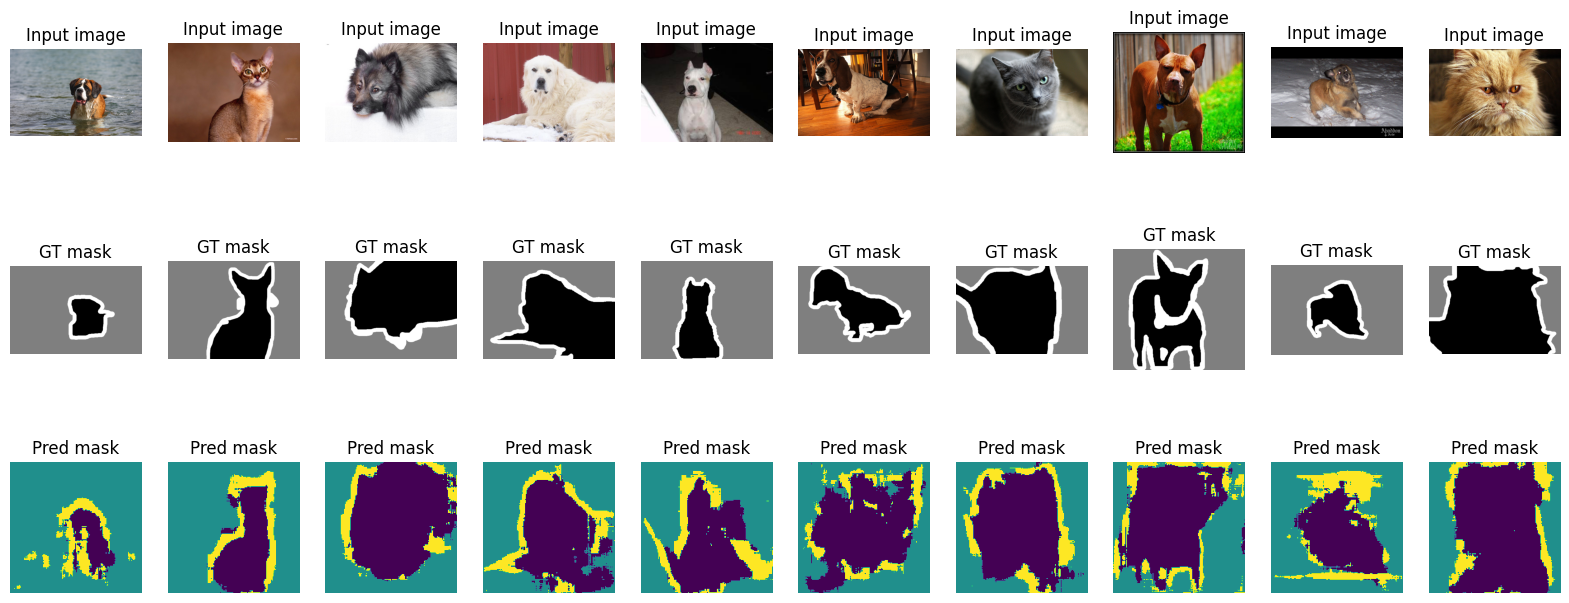

In [ ]:
from matplotlib import pyplot as plt
from PIL import ImageOps

def get_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    return img

# Display results for validation for 10 images
plt.figure(figsize=(20, 8))

for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.title("Input image")
    plt.axis("off")
    plt.imshow(keras.utils.load_img(val_input_img_paths[i]))

    # Display ground-truth target mask
    img = ImageOps.autocontrast(keras.utils.load_img(val_target_img_paths[i]))
    plt.subplot(3, 10, i + 11)
    plt.title("GT mask")
    plt.axis("off")
    plt.imshow(img)

    # Display mask predicted by our model
    plt.subplot(3, 10, i + 21)
    plt.title("Pred mask")
    plt.axis("off")
    plt.imshow(get_mask(i))


We're starting to see good predictive behaviour on the held-out validation set, which is very promising.

To turn this into a real performant network we likely need more training time, a bigger network, and more data of course.

But I would say this is a pretty good first step! Congratulations on implementing a working segmentation network!

## Pose Estimation

One of the coolest applications I can think of in computer vision is pose estimation.
It's so useful that it's practically used everywhere: Face pose, Hand pose, Object pose, Body pose, Animal body pose, and many more...

Pose is generally considered the estimation of the body Joints, e.g. L/R Shoulder, L/R Elbow, L/R wrist, L/R Hip, L/R Knee, etc.

We will implement a standard pose estimation algorithm based on a pre-trained efficient network (MobileNetV3) and a pose estimation head using heat-maps.

Heat-maps will predict the apporximate possible location of the pose Joint.

![image.png](attachment:image.png)

We can also add in an important other feature: Part-Affinity Maps / Fields. That effectively clue the model in on how the parts are connected in the "skeleton" so they stick together and don't diverge. However we will not implement PAF in this exercise.

We will follow loosely the seminal work of [Thompson et al](http://openaccess.thecvf.com/content_cvpr_2015/html/Tompson_Efficient_Object_Localization_2015_CVPR_paper.html) (which also includes Yann LeCun) "Efficient Object Localization Using Convolutional Networks".

In [ ]:
from keras import layers
import keras

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from matplotlib import pyplot as plt
import json
import os
import cv2
import numpy as np

2024-04-20 21:43:05.718744: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 21:43:10.931283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data Loading

To explore the vast diverse application space of pose estimation, instead of solving for human pose estimation, we will use a dataset of soccer field "pose estimation".

These are the "joints" of the soccer field "body":

(l = Left, p = Penalty, gb = Goal Box, c = Center/Corner, b = Bottom, t = Top. e.g. "lgbb" = Left Goal Box Bottom)

![soccer field annotation.png](<attachment:soccer field annotation.png>)

In [ ]:
!pip install gdown

In [ ]:
import gdown

file_id = '1fRDa8kxlvi2Fl32Uh97734UFHlXU_QnN'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'soccer_field_dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fRDa8kxlvi2Fl32Uh97734UFHlXU_QnN
From (redirected): https://drive.google.com/uc?id=1fRDa8kxlvi2Fl32Uh97734UFHlXU_QnN&confirm=t&uuid=4d43ce0f-93c6-4c9b-b363-2652f6705604
To: /mnt/c/Users/roysh/soccer_field_dataset.zip
100%|██████████| 420M/420M [00:05<00:00, 70.9MB/s] 


'soccer_field_dataset.zip'

In [ ]:
# unzip the dataset file with zipfile
import zipfile

with zipfile.ZipFile("soccer_field_dataset.zip", "r") as zip_ref:
    zip_ref.extractall("soccer_field_dataset")

#### Read Dataset Files

In [ ]:
# Adjust the path to match your dataset location, on colab it will be /content/soccer_field_dataset
IMG_DIR = "/mnt/c/Users/roysh/soccer_field_dataset/frames"

img_size = (224, 224)
heatmap_size = (28, 28)
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(IMG_DIR, fname)
        for fname in os.listdir(IMG_DIR)
        if fname.endswith(".png")
    ]
)
json_files = [
    os.path.splitext(fname)[0] + '.json'
    if os.path.exists(os.path.splitext(fname)[0] + '.json')
    else ''
    for fname in input_img_paths
]

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], json_files[:10]):
    print(input_path, "|", target_path)

Number of samples: 265
/mnt/c/Users/roysh/soccer_field_dataset/frames/000e1bad-ae21-491b-ace6-9fa8bdb0f327.png | 
/mnt/c/Users/roysh/soccer_field_dataset/frames/01137dec-638c-40f1-98fa-702439e2848b.png | /mnt/c/Users/roysh/soccer_field_dataset/frames/01137dec-638c-40f1-98fa-702439e2848b.json
/mnt/c/Users/roysh/soccer_field_dataset/frames/02d48106-4f4e-4eb0-a870-0db289b6fba8.png | 
/mnt/c/Users/roysh/soccer_field_dataset/frames/02fe7b1d-d3ef-470b-9b28-8076111d6672.png | /mnt/c/Users/roysh/soccer_field_dataset/frames/02fe7b1d-d3ef-470b-9b28-8076111d6672.json
/mnt/c/Users/roysh/soccer_field_dataset/frames/04e448d7-1500-4b6d-ad92-74c1af04ba54.png | /mnt/c/Users/roysh/soccer_field_dataset/frames/04e448d7-1500-4b6d-ad92-74c1af04ba54.json
/mnt/c/Users/roysh/soccer_field_dataset/frames/052029b8-baa0-4ed7-896d-22ea5e93b8c6.png | 
/mnt/c/Users/roysh/soccer_field_dataset/frames/054a5f2e-f71e-4be0-9489-7a677dcc8c73.png | 
/mnt/c/Users/roysh/soccer_field_dataset/frames/05779189-675a-44cb-af93-866c7

In [ ]:
all_labels = ['cc',
    'lcc',
    'ccb',
    'cct',
    'ct',
    'lpc',
    'lpt',
    'lpjt',
    'lgbt',
    'lpb',
    'lgbb',
    'lgc',
    'lct',
    'rpt',
    'rpc',
    'rpb',
    'rgc',
    'rgbt',
    'rpjt',
    'rct',
    'rcc',
    'rgbb',
    'lgbc',
    'lpjb',
    'rpjb',
    'rcb',
    'cb',
    'lcb',
    'lpjy'
]

#### Sample Visualization

Visualize a sample from the dataset

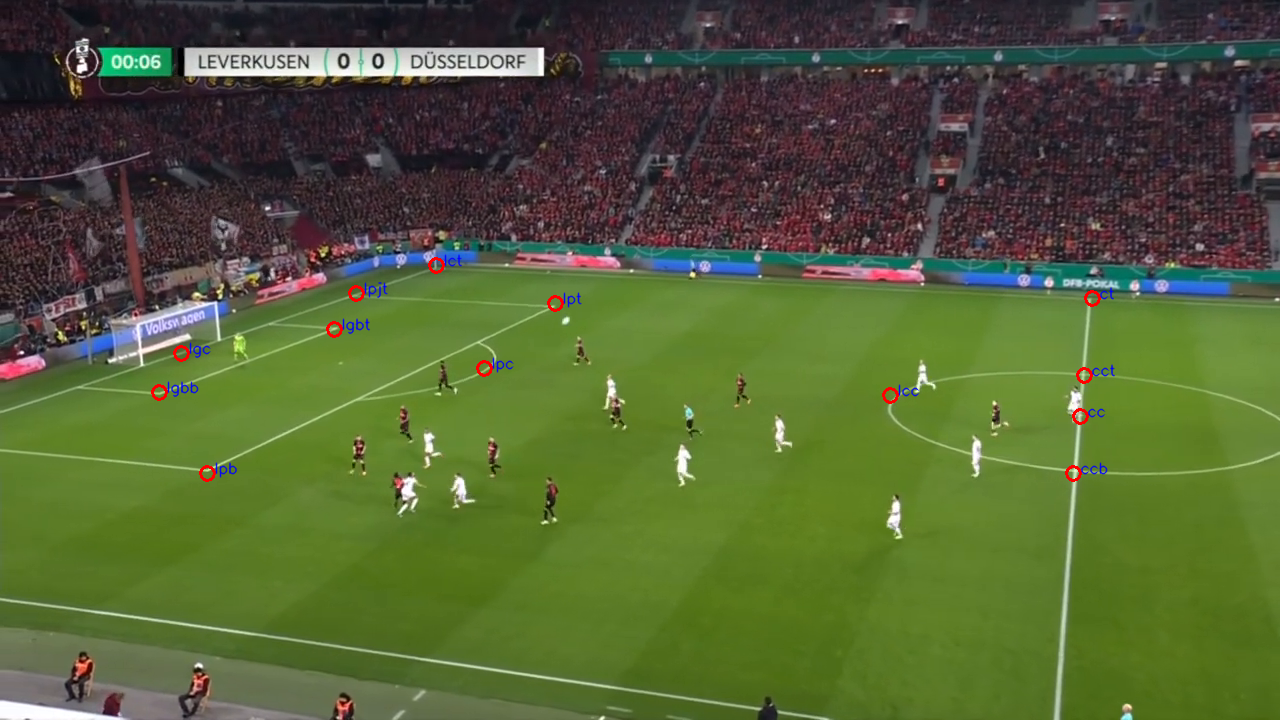

In [ ]:
# read an image file and visualize keypoints
def read_image_and_keypoints(img_path, json_path):
    img = Image.open(img_path)
    keypoints = []
    if json_path != '':
        with open(json_path) as f:
            data = json.load(f)
            for pt in data['shapes']:
                keypoints.append((pt['label'], (int)(pt['points'][0][0]), (int)(pt['points'][0][1])))
    return img, keypoints

# visualize keypoints on an image
def visualize_keypoints(img, keypoints):
    img = np.array(img)
    for keypoint in keypoints:
        label, x, y = keypoint
        cv2.circle(img, (x, y), 7, color=(255,0,0), thickness=2)
        cv2.putText(img, label, (x + 7, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    return Image.fromarray(img)

input_img, keypoints = read_image_and_keypoints(input_img_paths[1], json_files[1])
visualize_keypoints(input_img, keypoints)

#### Create a Training Dataset

Below are utility functions to read the dataset to prepare for training.

Follow along to learn...

In [ ]:
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

**Image augmentation**

Below I'm adding an image augmentation scheme, since the dataset is fairly small.

Augmentation serves as a regularizer, and helps with generalization.

In this case I'm adding only the occasional Affine transform with rotation and scaling.

In [ ]:
train_aug = iaa.Sequential(
    [
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.8, 1.1))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(img_size, interpolation="linear")])

Build a `tf.Dataset` for the soccer field dataset

In [ ]:
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import tensorflow as tf

def get_dataset_keypoints(
    batch_size,
    img_size,
    input_img_paths_,
    target_json_paths_,
    aug_pipeline,
    max_dataset_len=None,
    skip_samples=0,
):
    """Returns a TF Dataset."""

    def keypoint_augmentation(image, keypoints):
        kps = []

        # To apply our data augmentation pipeline, we first need to
        # form Keypoint objects with the original coordinates.
        for j in range(0, len(keypoints)):
            kps.append(Keypoint(x=keypoints[j][0], y=keypoints[j][1]))

        # We then project the original image and its keypoint coordinates.
        kps_obj = KeypointsOnImage(kps, shape=image.shape)

        # Apply the augmentation pipeline.
        (new_image, new_kps_obj) = aug_pipeline(image=image, keypoints=kps_obj)

        return new_image, new_kps_obj.to_xy_array()

    def create_image_and_heatmaps_from_json(target_json_path, orig_img, orig_img_shape):
        # try to load the json file if it exists
        if target_json_path == '':
            return orig_img, np.zeros((heatmap_size[0], heatmap_size[1], len(all_labels)), dtype=np.float32)

        with open(target_json_path) as f:
            target_json = json.load(f)

        # create keypoints for all classes from the json file
        keypoints = []
        for label in all_labels:
            kp = (-1, -1)
            for pt in target_json['shapes']:
                if pt['label'] == label:
                    x = int(pt['points'][0][0] * float(img_size[1]) / float(orig_img_shape[1]))
                    y = int(pt['points'][0][1] * float(img_size[0]) / float(orig_img_shape[0]))
                    kp = (x, y)
                    break
            keypoints.append(kp)

        # run augmentation on the keypoints and image
        output_image, output_keypoints = keypoint_augmentation(orig_img, keypoints)

        # Create a heatmap for each class
        heatmaps = np.zeros((len(all_labels), heatmap_size[0], heatmap_size[1]), dtype=np.float32)
        # order by the labels
        for i, label in enumerate(all_labels):
            # single channel heatmap
            if keypoints[i] != (-1, -1):
                x, y = output_keypoints[i]
                # convert from img_size to heatmap_size
                x = int(x * heatmap_size[1] / img_size[1])
                y = int(y * heatmap_size[0] / img_size[0])
                # draw a 2d Gaussian at the point
                cv2.circle(heatmaps[i], (int(x), int(y)), 2, color=(1,1,1,1), thickness=-1)
                # blur the heatmap to make it smooth
                heatmaps[i] = cv2.GaussianBlur(heatmaps[i], (5, 5), 0)
                # normalize the heatmap
                if np.max(heatmaps[i]) > 0:
                    heatmaps[i] = heatmaps[i] / np.max(heatmaps[i])
                else: # if the point is outside the image, set the heatmap to all zeros
                    heatmaps[i] = np.zeros((heatmap_size[0], heatmap_size[1]), dtype=np.float32)
        # convert heatmaps to channels last
        heatmaps = np.moveaxis(heatmaps, 0, -1)

        return output_image, heatmaps

    def load_img_and_create_heatmaps(input_img_path, target_json_path):
        # Convert tensor inputs to strings
        target_json_path = target_json_path.numpy().decode('utf-8')

        # read the image
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        orig_img_shape = tf.shape(input_img)
        input_img = tf_image.resize(input_img, img_size)
        # run the mobilenetv2 preprocessing
        input_img = tf.keras.applications.mobilenet_v2.preprocess_input(input_img)

        output_image, target_heatmaps = create_image_and_heatmaps_from_json(target_json_path, input_img.numpy(), orig_img_shape.numpy())
        return output_image, tf.convert_to_tensor(target_heatmaps, dtype=tf.float32)

    if max_dataset_len:
        input_img_paths_ = input_img_paths_[:max_dataset_len]
        target_json_paths_ = target_json_paths_[:max_dataset_len]
    if skip_samples > 0:
        input_img_paths_ = input_img_paths_[skip_samples:]
        target_json_paths_ = target_json_paths_[skip_samples:]

    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths_, target_json_paths_))

    # Apply the function using tf.py_function
    dataset = dataset.map(lambda image_path, json_path: tf.py_function(
        func=load_img_and_create_heatmaps,
        inp=[image_path, json_path],
        Tout=[tf.float32, tf.float32]
    ))
    # set the shape
    def set_shapes(image, heatmaps):
        image.set_shape([img_size[0], img_size[1], 3])
        heatmaps.set_shape([heatmap_size[0], heatmap_size[1], len(all_labels)])
        return image, heatmaps
    dataset = dataset.map(set_shapes)

    return dataset.batch(batch_size)

In [ ]:
# Instantiate dataset
train_dataset_keypoints = get_dataset_keypoints(
    16,
    img_size,
    input_img_paths,
    json_files,
    train_aug,
)

In [ ]:
# get an iterator
dataset_iter = iter(train_dataset_keypoints)

In [ ]:
# get a sample from the dataset
sample = next(dataset_iter)

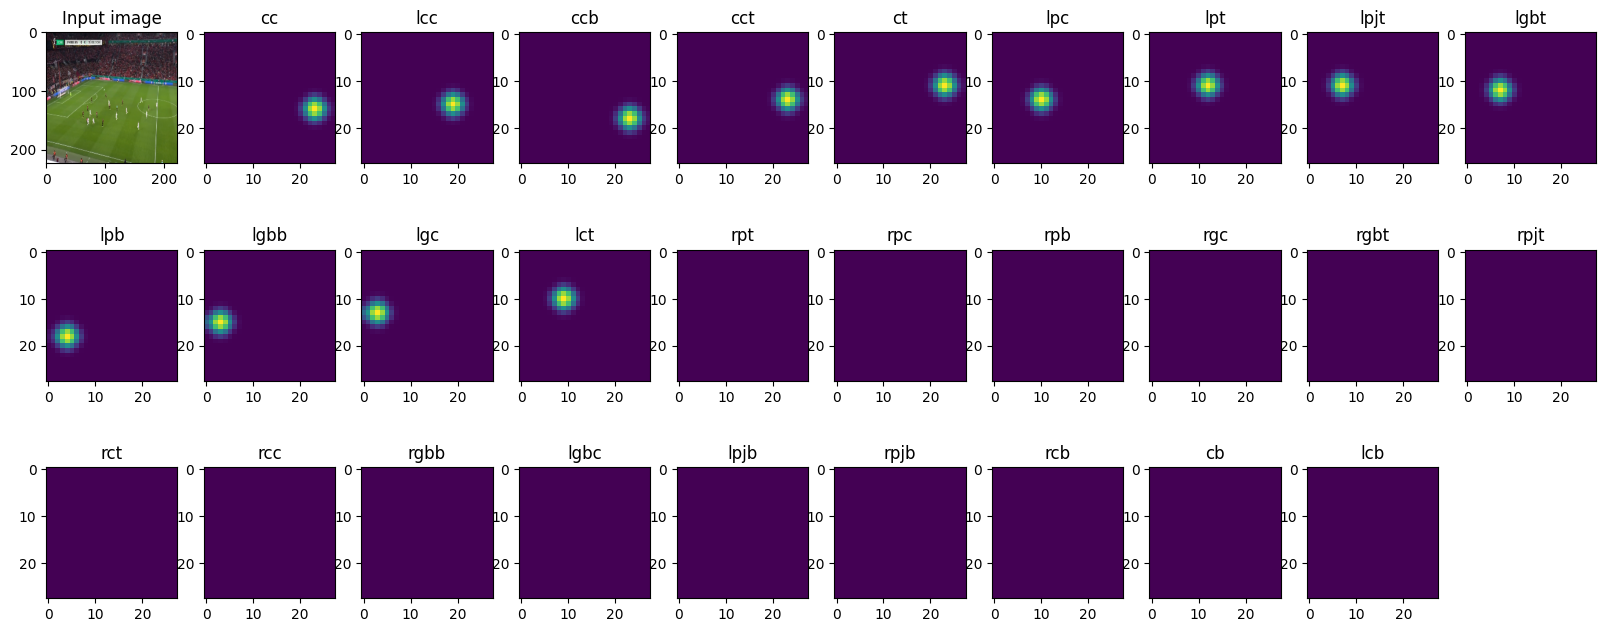

In [ ]:
# show one image and keypoint heatmaps
plt.figure(figsize=(20, 8))
plt.subplot(3, 10, 1)
plt.imshow((sample[0][1].numpy() + 1.0) / 2.0)
plt.title("Input image")
for i in range(28):
    plt.subplot(3, 10, i + 2)
    plt.imshow(sample[1][1,:,:,i])
    plt.title(all_labels[i])

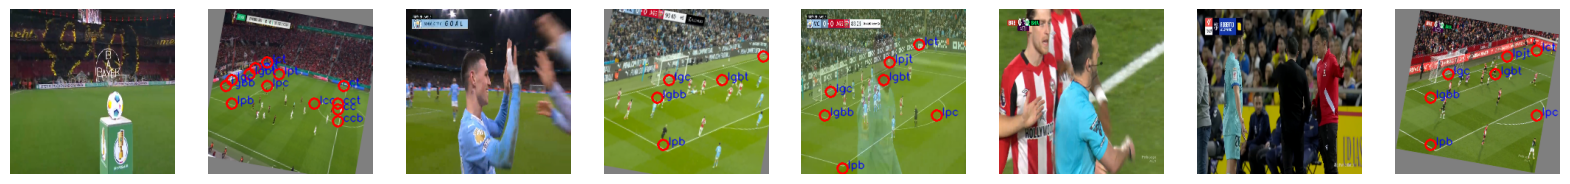

In [ ]:
def visualize_image_keypoints_from_heatmaps(image, heatmaps, threshold=0.5):
    # use the image as background
    img = (((image + 1.0) / 2.0) * 255.0).astype(np.uint8)
    # draw the keypoints on the image
    for i in range(heatmaps.shape[-1]):
        heatmap = heatmaps[:,:,i]
        # get the max value pixel
        y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
        if heatmap[y, x] > threshold:
            # convert from heatmap_size to img_size
            x = int(x * img_size[1] / heatmap_size[1])
            y = int(y * img_size[0] / heatmap_size[0])
            # draw a circle at the point
            cv2.circle(img, (x, y), 7, color=(255,0,0), thickness=2)
            cv2.putText(img, all_labels[i], (x + 7, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
    return img

# visualize the image and keypoints from the heatmaps for a whole batch
plt.figure(figsize=(20, 8))
for i in range(8):
    plt.subplot(3, 8, i + 1)
    plt.imshow(visualize_image_keypoints_from_heatmaps(sample[0][i].numpy(), sample[1][i]))
    plt.axis('off')

### Modeling

Let's build a fully-convolutional network to predict the heatmaps.

Examining [Thompson et al](https://arxiv.org/pdf/1411.4280.pdf) we observe they have a very simple CNN for "coarse" heatmap detection:

![image.png](attachment:image.png)

Notice it is fully convolutional, which is very efficient in amount of parameters. It only predicts heatmaps of 32x32 pixels, which they afterwards refine. We will implement this coarse level detection, however look in the paper on how they implement the fine detection step.

We can further improve our position by using a pretrained "backbone" (MobileNet V2 in our case), and simply add a head that will predict the heatmaps.

Let's try this simple approach.

In [ ]:
from keras.applications import MobileNetV2

def get_model():
    # connect the mobilenetv2 backbone's 'block_6_expand_relu' layer (28x28)
    # to a couple of conv layers that predict the keypoints heatmaps

    # get the MobileNetV2 backbone
    # remove the top layer by setting include_top=False
    # set weights to 'imagenet' to use the pretrained weights
    # set input_shape to img_size + (3,) to match the input size
    backbone = ...

    # get the features layer from the backbone
    # use the 'block_6_expand_relu' layer as the feature extractor
    # use .get_layer() to get the layer by name
    # and use .output to get the layer's output
    features = ...

    # create a keras.Model from the input layer to the features layer
    # freeze the feature extractor by setting .trainable = False
    feature_extractor = ...
    feature_extractor.trainable = False

    # create the model
    # start with the keras.Input layer with shape img_size + (3,)
    inputs = ...
    x = inputs

    # connect the input to the feature extractor by calling the feature_extractor
    x = feature_extractor(x)

    # add a couple of conv layers to predict the keypoints heatmaps
    # use layers.Conv2D 'same' padding and 'relu' activation, 128 filters, 3x3 kernel size
    x = ...
    # add layers.BatchNormalization after each conv layer to speed up training
    x = ...
    # same again
    x = ...
    x = ...

    # finally, add the output layer with the number of keypoints heatmaps
    # use layers.Conv2D with 'sigmoid' activation
    # the number of channels should be the number of keypoints (len(all_labels))
    # use a kernel size of 1 (1x1 convolution)
    x = ...

    # create the model
    model = keras.Model(inputs=inputs, outputs=x)
    return model

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 28, 28, 192)    │        65,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 29)     │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,557 (1.67 MB)

 Trainable params: 372,637 (1.42 MB)

 Non-trainable params: 65,920 (257.50 KB)

with just 372K parameters to train, our task is tractable.

Remember our dataset is very small (some 250 images).
With a bigger amount of parameters to train would be very hard to actually get the network to learn anything.

#### Loss Function

There are plenty of options for losses for keypoint detection. I'd like to focus on a couple.

First the Mean Squared Error. Insofar as our network is producing 29 28x28 heatmaps it makes sense to directly compare those pixel-to-pixel with the ground truth.

[Thompson et al](https://arxiv.org/pdf/1411.4280.pdf) also use a simple MSE, e.g.

![image.png](attachment:image.png)

However, the MSE has several downsides. Primarily, it is not "task specific", in other words it doesn't know we're looking at keypoint heatmaps.

Our heatmaps have a single "bright spot" and the Mean part of MSE might (will) drive the network to predict all zeros - and get a very low loss.

To combat this, we will implement a Euclidean Distance loss based on the heatmaps. This loss came into popularity in more advanced works that came afterwards.

The distance loss is simple: extract the 2D positions of the keypoints from the maps and calculate the mean Euclidean distance.

$$
L_{\text{Euclid}} = \frac{1}{N} \sum_{i=1}^n \sqrt{(x_i - x'_i)^2 + (y_i - y'_i)^2}
$$

Getting the 2D points is the crux of the matter.

However! Again such a loss may (will) drive the network to predict all the keypoints in the center of the image - close to any point in the image, and get a low loss.

To combat that knock-on problem, we can add a "dispersion" term to the loss to prevent the network of detecting all the keypoints in a single location.

We can calculate the standard deviation for all (valid) keypoints and look for an inverse relation, e.g. when the stdev is smaller - the loss is bigger.

$$
L_{\text{std}} = \frac{1}{\sqrt{\frac{1}{N'} \sum_{i=1}^n \mathbb{1}(p_i \neq \text{null}) \cdot ((p_i - \mu)^2)}}
$$

Notice that we need an indicator to only select the valid keypoints for this calculation.

Finally we mix all the losses with weights:

$$
L = \lambda_{\text{MSE}}L_{\text{MSE}} + \lambda_{\text{Euclid}}L_{\text{Euclid}} + \lambda_{\text{std}}L_{\text{std}}
$$

In [ ]:
import tensorflow as tf

def soft_argmax(heatmaps, epsilon=1e-6):
    '''
    Calculate the expected value of the coordinates from the heatmap

    I'm providing this function for you to use in the custom loss function,
    since some of the indexing and masking can get quite hairy.

    heatmaps: (N, H, W, C) tensor
    epsilon: small value to prevent NaN in log
    return: (N, C, 2) tensor
    '''
    shape = tf.shape(heatmaps)
    N = shape[0]
    H = shape[1]
    W = shape[2]
    C = shape[3]

    heatmaps_flat = tf.reshape(heatmaps, (N, H * W, C))
    softmax = tf.nn.softmax(heatmaps_flat + 1e-10, axis=1)
    indices = tf.range(H * W)
    indices = tf.reshape(indices, (1, H * W, 1))
    indices = tf.tile(indices, (N, 1, C))

    x = indices % W
    y = indices // W

    x = tf.cast(x, tf.float32)
    y = tf.cast(y, tf.float32)

    # Normalize x and y to prevent NaN or Inf in case of empty heatmaps
    max_val = tf.reduce_max(heatmaps_flat, axis=1, keepdims=True)
    is_active = tf.greater(max_val, epsilon)  # True if heatmap has meaningful values

    x = tf.where(is_active, x, 0.0)
    y = tf.where(is_active, y, 0.0)

    expected_x = tf.reduce_sum(softmax * x, axis=1)
    expected_y = tf.reduce_sum(softmax * y, axis=1)

    # Handle the case of completely empty heatmaps
    expected_x = tf.where(tf.reduce_any(is_active, axis=1), expected_x, tf.zeros_like(expected_x))
    expected_y = tf.where(tf.reduce_any(is_active, axis=1), expected_y, tf.zeros_like(expected_y))

    return tf.stack([expected_x, expected_y], axis=-1)

def custom_euclidean_loss(y_true, y_pred):
    # calculate the plain mse loss
    # use tf.reduce_mean and tf.square to calculate the mean squared error
    mse = ...

    # calculate the euclidean distance between the true and predicted keypoints
    # use the soft_argmax function to get the coordinate of the keypoints
    true_coords = soft_argmax(y_true)
    pred_coords = soft_argmax(y_pred)
    # use tf.norm to calculate the euclidean distance between the true and predicted keypoints
    # remember to set the axis to 1
    distances = ...
    # calculate the mean of the distances with tf.reduce_mean
    distances_loss = ...

    # Advanced: "dispersion penalty"
    # prevent the predicted locations to converge on a single point
    # calculate the mask where the predicted keypoints are not zero
    # use tf.reduce_max to get the maximum value along the last axis (-1)
    # and compare it to zero (e.g. > 0)
    pred_coords_mask = ...
    # calculate the stdev where the mask is true
    # use tf.math.reduce_std and tf.boolean_mask of pred_coords with pred_coords_mask
    # use axis=0
    pred_coords_std = ...
    # create a loss to prevent very small stdev, ecourage it to be bigger
    # the penalty is higher when the stdev is smaller
    # use an inverse ratio e.g. 1 / (mean(std) + epsilon)
    # make sure to add epsilon to prevent division by zero
    dispersion_penalty = ...

    # return the sum of the mse loss, distances loss, and dispersion penalty
    # i've found that the mse loss and the distances loss are of different magnitudes
    # so i've used the coefficients 100000.0, 1.0 and 50.0 respectively to balance them

    return ... # distances_loss * ...

In [ ]:
# test the custom loss function with a sample just to see if it runs
y_true = tf.convert_to_tensor(sample[1][0:4], dtype=tf.float32)
y_pred = tf.convert_to_tensor(sample[1][1:5], dtype=tf.float32)
custom_euclidean_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=775.2383>

### Training the model

In [ ]:
# reinitialize the model
model = get_model()

We're going to use a Learning Rate Schedule. This is will allow different parts of the training to have different LR, which is useful in many cases.

Simply put, at the beginning when we're exploring the loss space we can have a bigger LR, and then as we're approaching the (local) minimum we can reduce the LR to make smaller steps so to get into the "funnel" of the minimum instead of jumping over it with a big LR.

Having a smaller LR for bigger loss improvement may seems counterintuitive, but it in fact it makes a lot of sense.

As you'll see in the example below, notice when we drop the LR the loss actually starts decreasing faster! It's a miracle!

In [ ]:
initial_learning_rate = 0.01
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=200,
    decay_rate=0.96,
    staircase=True)

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=custom_euclidean_loss)

In [ ]:
# Train the model
history = model.fit(
    train_dataset_keypoints,
    epochs=50,
)

Epoch 1/50


17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 21339.0977
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - loss: 1592.1689
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 563ms/step - loss: 1035.1232
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 561ms/step - loss: 939.0150
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 561ms/step - loss: 733.6185
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - loss: 691.2023
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 587ms/step - loss: 682.5845
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - loss: 665.7703
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 572ms/step - loss: 662.7656
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 589ms/step - loss: 662.1265
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 597ms/step - loss: 656.5953
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 592ms/step - loss: 650.2442
Epoch 13/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 586ms/step - loss: 649.6346
Epoch 14/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 652ms/step - loss: 648.4830
Epoch 15/50
17/17 ━━━━━━━

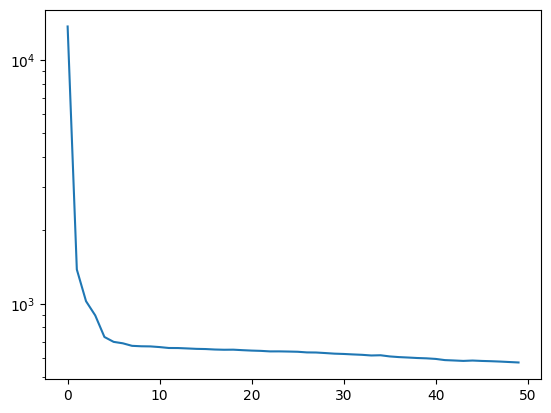

In [ ]:
# plot the loss history on a log scale
plt.plot(history.history['loss'], label='loss')
plt.yscale('log')

#### Visualize Results

In [ ]:
predicted_heatmaps_batch = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


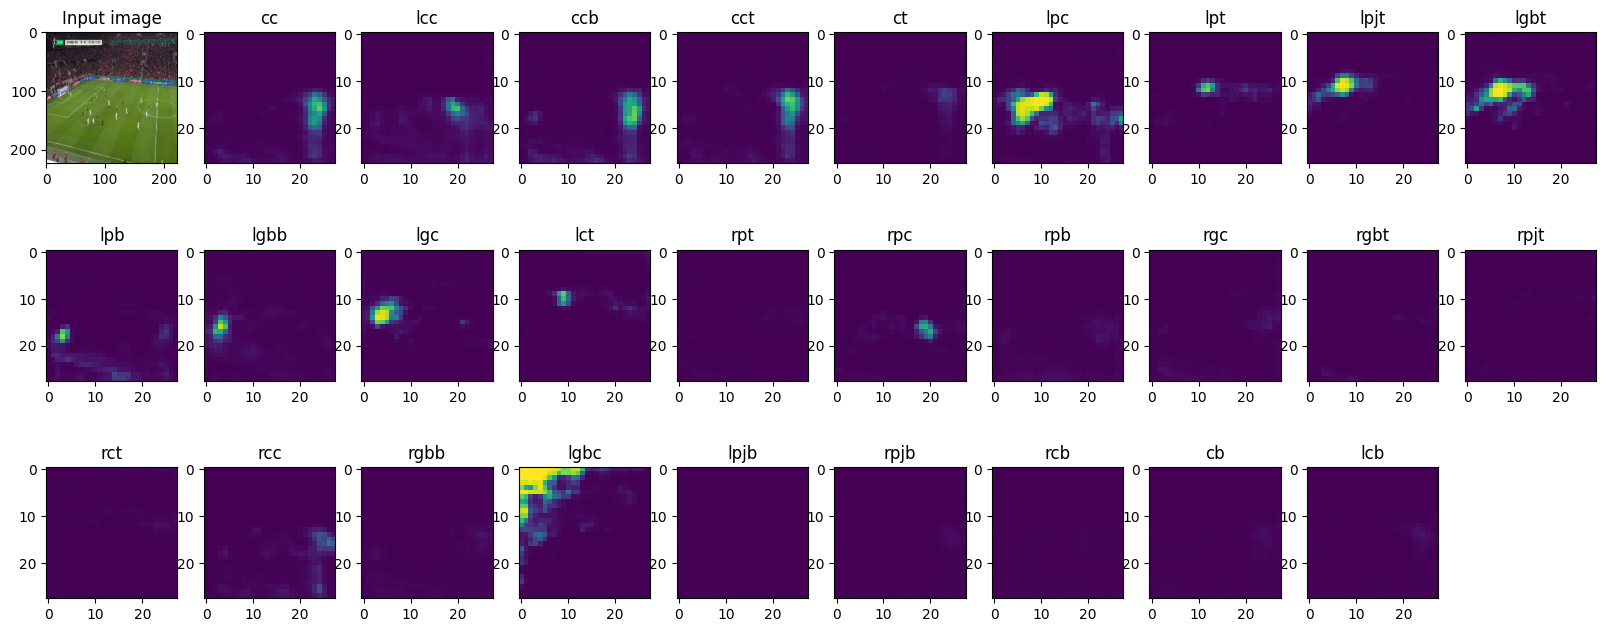

In [ ]:
# show one image and keypoint heatmaps
sample_i = 1
plt.figure(figsize=(20, 8))
plt.subplot(3, 10, 1)
plt.imshow((sample[0][sample_i].numpy() + 1.0) / 2.0)
plt.title("Input image")
for i in range(28):
    plt.subplot(3, 10, i + 2)
    plt.imshow(predicted_heatmaps_batch[sample_i,:,:,i], vmin=0, vmax=1)
    plt.title(all_labels[i])

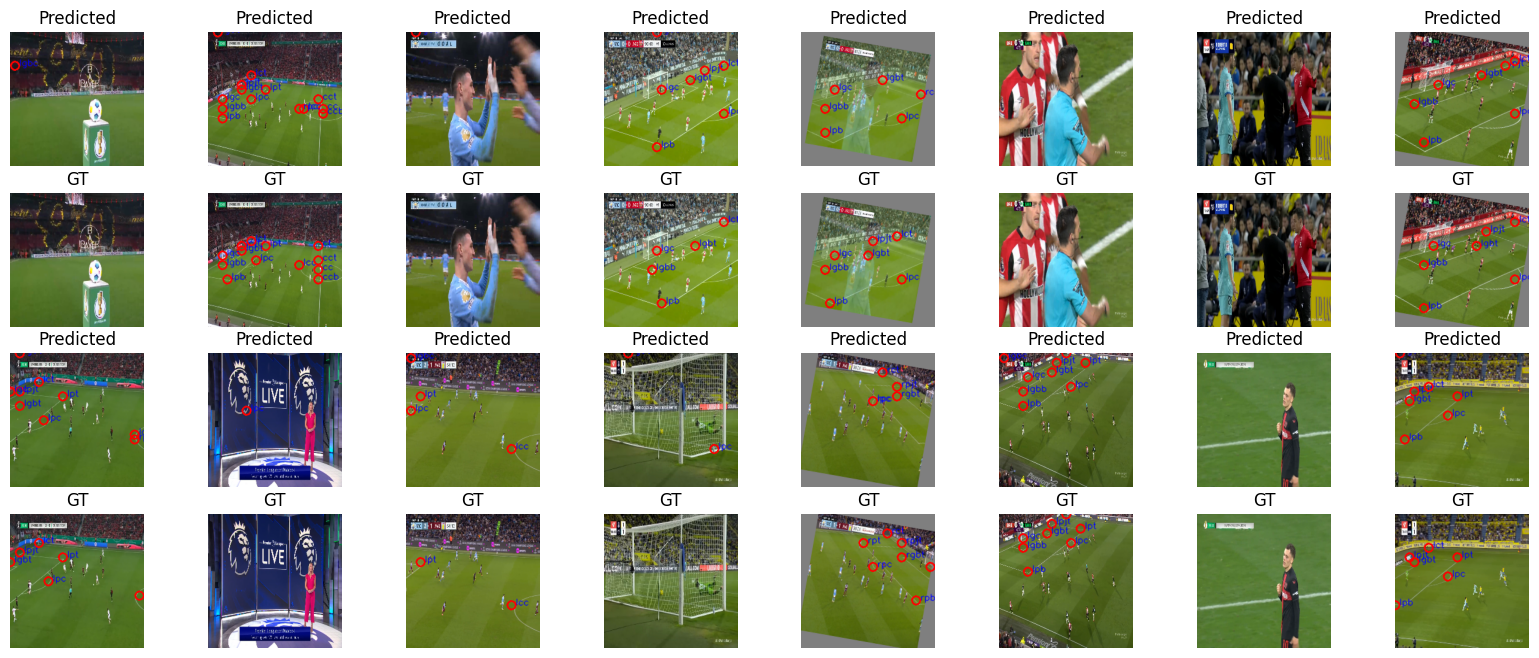

In [ ]:
# visualize the image and keypoints from the heatmaps for a whole batch
plt.figure(figsize=(20, 8))
for i in range(16):
    plt.subplot(4, 8, i + 1 + 8 * (i // 8))
    plt.imshow(visualize_image_keypoints_from_heatmaps(sample[0][i].numpy(), predicted_heatmaps_batch[i], 0.4))
    plt.axis('off')
    plt.title('Predicted')

    plt.subplot(4, 8, i + 9 + 8 * (i // 8))
    plt.imshow(visualize_image_keypoints_from_heatmaps(sample[0][i].numpy(), sample[1][i]))
    plt.axis('off')
    plt.title('GT')

The results are looking quite good. Very impressive for a 300K trainable-parameter network that you trained in <10 minutes on modest hardware.

Again, we're not taking into account overfitting and other potential problems, rather focusing on getting the network to learn *something*.

A real solution would need refinement of the keypoints as well as careful training that will result in a generalizing model.

That's a wrap! Thanks for playing